# Research Skills: Spatiotemporal Data Analyis

Individual assignment

Department of Cognitive Science and Artificial Intelligence,
Tilburg University
Academic Year 2023-2024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Spatiotemporal Data/Assignment Part 2

/content/drive/MyDrive/Colab Notebooks/Spatiotemporal Data/Assignment Part 2


In [ ]:
!pip install geopandas
!pip install libpysal
!pip install spreg
!pip install esda
!pip install mapclassify

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import libpysal as ps
import geopandas as gpd
import esda as es
import spreg
import copy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit, train_test_split, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, SGDRegressor

# Part 2
## Predicting the percentage of votes for a party in the 2023 Netherlands election with spatial autoregression


1. [4 points] You are provided with your own dataset of election results (XXXXX spatial:csv).

* (a) Compute the percentage of votes the party received in each municipality. This is your targe variable.

* (b) Create a histogram plot of your target variable and the features; average income, average house price and population density. Are the target variable and features normally distributed?

The target variable and the features are not normally distributed but are right skewed. Values are concentrated on the left.

In [ ]:
# load the election data
election = pd.read_csv('2112066_spatial.csv')
election.head()

,GM_NAAM,GM_CODE,OuderRegioCode,GrootOuderRegioCode,total_votes,VVD,Average_House_Price,Average_Income,Population_Density,Population_Increase
0,Eemsdelta,GM1979,K1,P20,26604,2384,180.0,22.0,169,-233
1,Groningen,GM0014,K1,P20,146649,15573,258.9,23.3,1266,57
2,Het Hogeland,GM1966,K1,P20,31424,2658,188.8,22.1,101,-188
3,Midden-Groningen,GM1952,K1,P20,36402,3838,206.7,22.0,219,-202
4,Oldambt,GM1895,K1,P20,23631,2351,175.8,21.3,170,-219


In [ ]:
print(election.shape)

(342, 10)


In [ ]:
# compute the percentage of votes in each municipality
election['Percentage_votes'] = election['VVD'] / election['total_votes']
election.head()

,GM_NAAM,GM_CODE,OuderRegioCode,GrootOuderRegioCode,total_votes,VVD,Average_House_Price,Average_Income,Population_Density,Population_Increase,Percentage_votes
0,Eemsdelta,GM1979,K1,P20,26604,2384,180.0,22.0,169,-233,0.089611
1,Groningen,GM0014,K1,P20,146649,15573,258.9,23.3,1266,57,0.106192
2,Het Hogeland,GM1966,K1,P20,31424,2658,188.8,22.1,101,-188,0.084585
3,Midden-Groningen,GM1952,K1,P20,36402,3838,206.7,22.0,219,-202,0.105434
4,Oldambt,GM1895,K1,P20,23631,2351,175.8,21.3,170,-219,0.099488


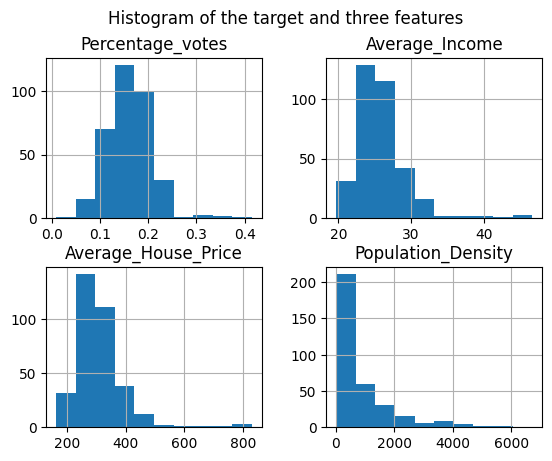

In [ ]:
# histogram of the target variable and three features
cols = ['Percentage_votes', 'Average_Income', 'Average_House_Price', 'Population_Density']
hist_df = election[cols]

hist = hist_df.hist()
plt.suptitle('Histogram of the target and three features')
plt.show()

2. [2 points] Perform a log transformation of your target variable, population density, average income and
average house price features.

In [ ]:
# Perform a log transformation
log_cols = ['Percentage_votes_log', 'Average_Income_log', 'Average_House_Price_log', 'Population_Density_log']
election[log_cols] = election[cols].apply(np.log1p)
election.head()

,GM_NAAM,GM_CODE,OuderRegioCode,GrootOuderRegioCode,total_votes,VVD,Average_House_Price,Average_Income,Population_Density,Population_Increase,Percentage_votes,Percentage_votes_log,Average_Income_log,Average_House_Price_log,Population_Density_log
0,Eemsdelta,GM1979,K1,P20,26604,2384,180.0,22.0,169,-233,0.089611,0.085820,3.135494,5.198497,5.135798
1,Groningen,GM0014,K1,P20,146649,15573,258.9,23.3,1266,57,0.106192,0.100924,3.190476,5.560297,7.144407
2,Het Hogeland,GM1966,K1,P20,31424,2658,188.8,22.1,101,-188,0.084585,0.081197,3.139833,5.245971,4.624973
3,Midden-Groningen,GM1952,K1,P20,36402,3838,206.7,22.0,219,-202,0.105434,0.100238,3.135494,5.336095,5.393628
4,Oldambt,GM1895,K1,P20,23631,2351,175.8,21.3,170,-219,0.099488,0.094845,3.104587,5.175019,5.141664


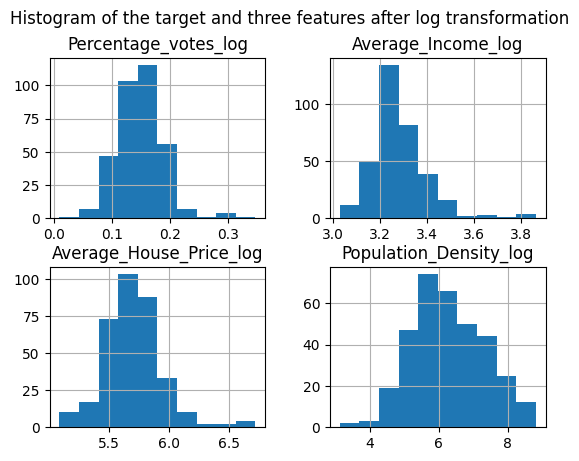

In [ ]:
# check the distribution of logged values
hist_df = election[log_cols]
hist = hist_df.hist()
plt.suptitle('Histogram of the target and three features after log transformation')
plt.show()

3. [6 points] You are provided with a shape file of municipalities level of the Netherlands. Provide code to perform the following:

* (a) Load the shapefile of the townships of the Netherlands and display the first five rows. Remove all the polygons (and multipolygons) representing water. Note, you do not have to display the Choropleth Map of your results, but you can if you want to.  

* (b) Create a new column called `Pct_Votes` in the geodataframe and copy over the contents in column containing the percentage of votes in the dataframe from Question 1. Drop all the rows with missing values. (Hint: you can use the 'join' or 'merge' function in pandas)

* (c) Display a Choropleth Map of the townships, with colors assigned `Pct_Votes` (`columns=Pct_Votes`). Use a quantiles scheme with 5 quantiles.

In [ ]:
# load the shapefile
town = gpd.read_file(join('wijkbuurtkaart_2023_v1', 'gemeenten_2023_v1.shp'))
town.head()

,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,P_GEBBL_EU,P_GEBBL_NE,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,layer,path,geometry
0,GM0034,Almere,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0034,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((150087.299 479382.379, 150000...."
1,GM0050,Zeewolde,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0050,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((155047.32 474836.246, 155049.0..."
2,GM0060,Ameland,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0060,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((196000 608000, 195250 607500, 193000..."
3,GM0072,Harlingen,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0072,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((158000 581000, 158331.38 58046..."
4,GM0088,Schiermonnikoog,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0088,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((219000 616201.447, 219000 616000, 21..."


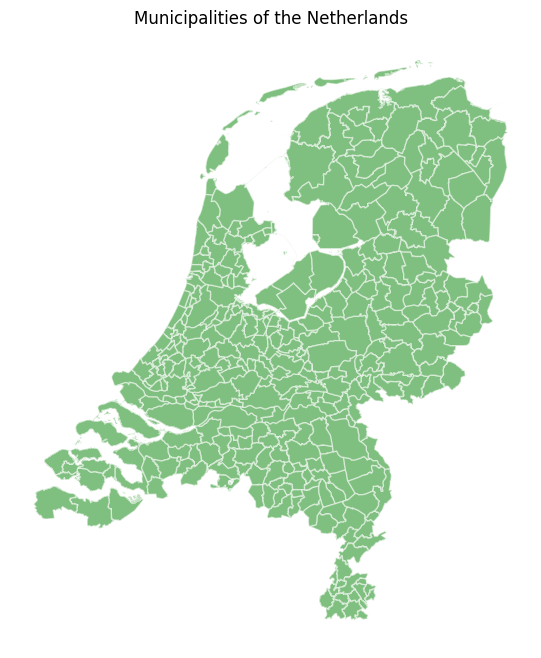

In [ ]:
# remove all the polygons (and multipolygons) representing water
town = town[town['H2O'] != 'JA']
ax = town.plot(figsize=(8, 8), alpha=0.5, facecolor='g', edgecolor='w')
plt.title('Municipalities of the Netherlands')
ax.set_axis_off()
plt.show()

In [ ]:
# set index of the two dataset to prepare for merging
election = election.set_index('GM_CODE')
election.head()

,GM_NAAM,OuderRegioCode,GrootOuderRegioCode,total_votes,VVD,Average_House_Price,Average_Income,Population_Density,Population_Increase,Percentage_votes,Percentage_votes_log,Average_Income_log,Average_House_Price_log,Population_Density_log
GM_CODE,,,,,,,,,,,,,,
GM1979,Eemsdelta,K1,P20,26604,2384,180.0,22.0,169,-233,0.089611,0.085820,3.135494,5.198497,5.135798
GM0014,Groningen,K1,P20,146649,15573,258.9,23.3,1266,57,0.106192,0.100924,3.190476,5.560297,7.144407
GM1966,Het Hogeland,K1,P20,31424,2658,188.8,22.1,101,-188,0.084585,0.081197,3.139833,5.245971,4.624973
GM1952,Midden-Groningen,K1,P20,36402,3838,206.7,22.0,219,-202,0.105434,0.100238,3.135494,5.336095,5.393628
GM1895,Oldambt,K1,P20,23631,2351,175.8,21.3,170,-219,0.099488,0.094845,3.104587,5.175019,5.141664


In [ ]:
town = town.set_index('GM_CODE')
town.head()

,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,P_GEBBL_EU,P_GEBBL_NE,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,layer,path,geometry
GM_CODE,,,,,,,,,,,,,,,,,,,,,
GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,21.0,...,8.0,10.0,19796.0,18553.0,1243.0,2023GM0014,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((245229.7 592570.87, 245250.71 592551..."
GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,12.0,...,5.0,21.0,24877.0,12918.0,11959.0,2023GM0034,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((142993.709 482642.714, 142993...."
GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,11.0,...,2.0,4.0,11994.0,11763.0,231.0,2023GM0037,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((263763.866 566430.392, 263944.283 56..."
GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,11.0,...,2.0,5.0,7868.0,7593.0,275.0,2023GM0047,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((256504.591 572265.478, 256541.115 57..."
GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,13.0,...,8.0,5.0,26886.0,24711.0,2175.0,2023GM0050,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((165488.532 478414.424, 165480...."


In [ ]:
# create a new column and drop missing values
town = town.merge(election[['Percentage_votes']], on='GM_CODE', how='left')
town.rename(columns={'Percentage_votes': 'Pct_Votes'}, inplace=True)
town = town.dropna()
town.head()

,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,P_GEBBL_NE,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,layer,path,geometry,Pct_Votes
GM_CODE,,,,,,,,,,,,,,,,,,,,,
GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,21.0,...,10.0,19796.0,18553.0,1243.0,2023GM0014,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((245229.7 592570.87, 245250.71 592551...",0.106192
GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,12.0,...,21.0,24877.0,12918.0,11959.0,2023GM0034,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((142993.709 482642.714, 142993....",0.158361
GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,11.0,...,4.0,11994.0,11763.0,231.0,2023GM0037,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((263763.866 566430.392, 263944.283 56...",0.083993
GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,11.0,...,5.0,7868.0,7593.0,275.0,2023GM0047,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((256504.591 572265.478, 256541.115 57...",0.105651
GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,13.0,...,5.0,26886.0,24711.0,2175.0,2023GM0050,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((165488.532 478414.424, 165480....",0.176822


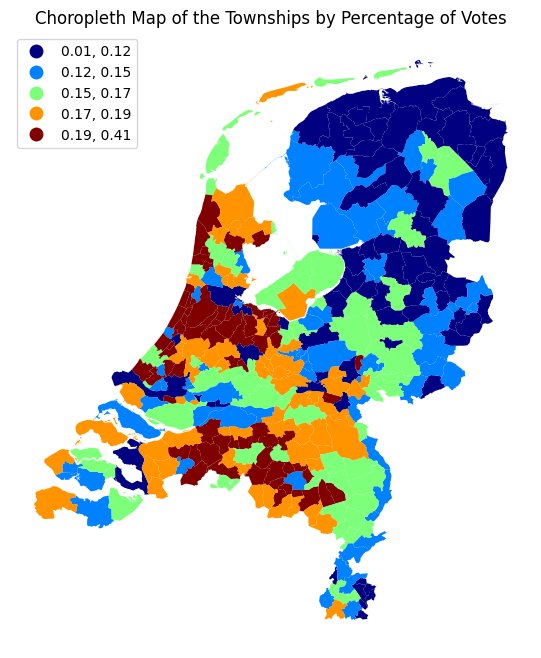

In [ ]:
# Display a Choropleth Map of the townships
fig, ax = plt.subplots(figsize=(8, 8))
town.plot(column='Pct_Votes', scheme='QUANTILES', k=5, cmap='jet', legend=True, ax=ax, legend_kwds={'loc': 'upper left'})
plt.title('Choropleth Map of the Townships by Percentage of Votes')
ax.set_axis_off()
plt.show()

4. [6 points] Using contiguity based weighting schemes (rook and queen) and KNN based weighing schemes,
compute and compare the global autocorrelation (Global Moran's I) of the log transformation of the `Pct_Votes`. Try at least 3 different K number of neighbours.

In [ ]:
# merge the logged form of Pct_Votes into the dataset
town = town.merge(election[['Percentage_votes_log']], on='GM_CODE', how='left')
town.rename(columns={'Percentage_votes_log': 'Pct_Votes_log'}, inplace=True)
town.head()

,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,layer,path,geometry,Pct_Votes,Pct_Votes_log
GM_CODE,,,,,,,,,,,,,,,,,,,,,
GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,21.0,...,19796.0,18553.0,1243.0,2023GM0014,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((245229.7 592570.87, 245250.71 592551...",0.106192,0.100924
GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,12.0,...,24877.0,12918.0,11959.0,2023GM0034,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((142993.709 482642.714, 142993....",0.158361,0.147006
GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,11.0,...,11994.0,11763.0,231.0,2023GM0037,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((263763.866 566430.392, 263944.283 56...",0.083993,0.080651
GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,11.0,...,7868.0,7593.0,275.0,2023GM0047,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((256504.591 572265.478, 256541.115 57...",0.105651,0.100434
GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,13.0,...,26886.0,24711.0,2175.0,2023GM0050,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((165488.532 478414.424, 165480....",0.176822,0.162818


In [ ]:
# compute the Global Moran's I
results = {}

rook_weights = ps.weights.Rook.from_dataframe(town, use_index=True)
rook_weights2 = copy.deepcopy(rook_weights)
mi1 = es.Moran(town['Pct_Votes_log'], rook_weights2)
results['rook'] = {'I_statistics': mi1.I, 'p_value': mi1.p_sim}

queen_weights = ps.weights.Queen.from_dataframe(town, use_index=True)
queen_weights2 = copy.deepcopy(queen_weights)
mi2 = es.Moran(town['Pct_Votes_log'], queen_weights2)
results['queen'] = {'I_statistics': mi2.I, 'p_value': mi2.p_sim}

for k in [1, 3, 5, 7, 9]:
  KNN_weights = ps.weights.distance.KNN.from_dataframe(town, k=k)
  KNN_weights2 = copy.deepcopy(KNN_weights)
  mi3 = es.Moran(town['Pct_Votes_log'], KNN_weights2)
  results[f'KNN_{k}'] = {'I_statistics': mi3.I, 'p_value': mi3.p_sim}

/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: GM0060.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 'GM0060', ' is an island (no neighbors)')


/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: GM0060.
  W.__init__(self, neighbors, ids=ids, **kw)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 82 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


('WARNING: ', 'GM0060', ' is an island (no neighbors)')


In [ ]:
# compare the results
results_sorted = dict(sorted(results.items(),
                             key=lambda x: x[1]['I_statistics'],
                             reverse = True))
for key, value in results_sorted.items():
  print('{} has I statistic of {} and p value of {}'.format(key,
                                                            str(round(value['I_statistics'], 3)),
                                                            str(value['p_value'])))

KNN_3 has I statistic of 0.567 and p value of 0.001
KNN_1 has I statistic of 0.552 and p value of 0.001
KNN_5 has I statistic of 0.5 and p value of 0.001
rook has I statistic of 0.477 and p value of 0.001
KNN_7 has I statistic of 0.477 and p value of 0.001
queen has I statistic of 0.475 and p value of 0.001
KNN_9 has I statistic of 0.47 and p value of 0.001


5. [8 points] Compute the local autocorrelation. Choose the weighting scheme and parameters for which
gave you the highest correlation in Q4. Identify the 'hotspots' and 'coldspots' by displaying the hotspots as these townships with different colors in a scatter plot or Choropleth map.

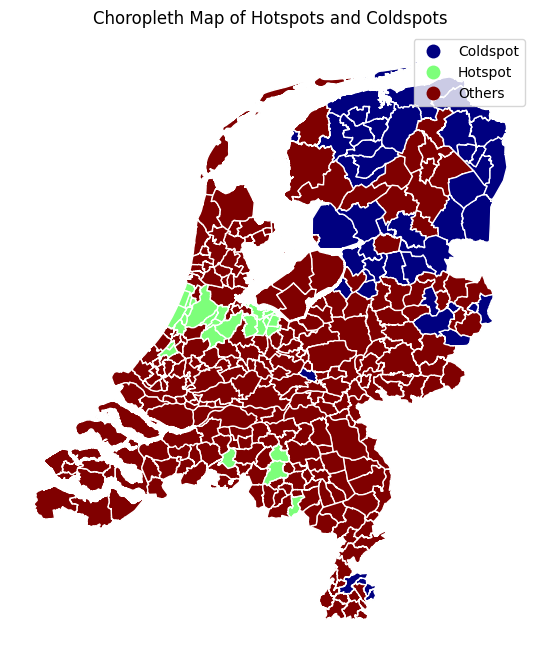

In [ ]:
# compute the local autocorrelation
KNN3_weights = ps.weights.distance.KNN.from_dataframe(town, k=3)
KNN3_weights.transform = 'R'
I_votes = es.Moran_Local(town['Pct_Votes_log'], KNN3_weights)

# find the hotspots and coldspots
sig = I_votes.p_sim < 0.05

hotspot = sig * I_votes.q == 1
coldspot = sig * I_votes.q == 3

# plot the hotspots and coldspots
town.assign(cl=np.select([hotspot, coldspot], ['Hotspot', 'Coldspot'], default='Others')).plot(figsize=(8, 8), column='cl', cmap='jet', edgecolor='w', legend=True)
plt.title('Choropleth Map of Hotspots and Coldspots')
plt.axis('off')
plt.show()

6. [10 points] Your goal is to estimate the `Pct_Votes` (log values) per municipality based on the explanatory variables (the average house price and population density) and the spatially lagged `Pct_Votes` (endognous regressor). Please use the log form of the variables from Question 2 for this question. Please use "spreg" package for this task. Chose one weighing scheme and

* (a) Fit a linear regression model, where your target variable is the `Pct_Votes` (in log form) and your features (exploratory variables) are population density, average income and average house price features (in log form)

* (b) Using the GM_Lag, run a spatial autoregression model with the features in (a)

* Compute the mean square error for these 2 estimators. Which regressor model resulted in the lowest mean square error?

The linear regression model has lower mean squared error.

In [ ]:
# merge the explanatory variables into the dataset
town = town.merge(election[['Average_Income_log', 'Average_House_Price_log', 'Population_Density_log']], on='GM_CODE', how='left')
town.dropna(axis=0, how='any', inplace=True)
town.head()

,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,JRSTATCODE,JAAR,layer,path,geometry,Pct_Votes,Pct_Votes_log,Average_Income_log,Average_House_Price_log,Population_Density_log
GM_CODE,,,,,,,,,,,,,,,,,,,,,
GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,21.0,...,2023GM0014,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((245229.7 592570.87, 245250.71 592551...",0.106192,0.100924,3.190476,5.560297,7.144407
GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,12.0,...,2023GM0034,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((142993.709 482642.714, 142993....",0.158361,0.147006,3.246491,5.687992,7.430707
GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,11.0,...,2023GM0037,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((263763.866 566430.392, 263944.283 56...",0.083993,0.080651,3.068053,5.228431,5.605802
GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,11.0,...,2023GM0047,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((256504.591 572265.478, 256541.115 57...",0.105651,0.100434,3.117950,5.239098,5.894403
GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,13.0,...,2023GM0050,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((165488.532 478414.424, 165480....",0.176822,0.162818,3.284664,5.622934,4.553877


In [ ]:
# fit linear regression model
variable_names = ['Average_Income_log', 'Average_House_Price_log', 'Population_Density_log']
m1 = spreg.OLS(town['Pct_Votes_log'].values, town[variable_names].values, name_y='Pct_Votes_log', name_x=variable_names)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Pct_Votes_log                Number of Observations:         342
Mean dependent var  :      0.1484                Number of Variables   :           4
S.D. dependent var  :      0.0402                Degrees of Freedom    :         338
R-squared           :      0.7290
Adjusted R-squared  :      0.7266
Sum squared residual:     0.14937                F-statistic           :    303.0938
Sigma-square        :       0.000                Prob(F-statistic)     :   1.854e-95
S.E. of regression  :       0.021                Log likelihood        :     837.603
Sigma-square ML     :       0.000                Akaike info criterion :   -1667.205
S.E of regression ML:      0.0209                Schwarz criterion     :   -1651.866

-----------------------------------------------------------

In [ ]:
# calculate the distance weights
weights = ps.weights.distance.KNN.from_dataframe(town, k=3)
weights.transform = 'R'

# fit a spatial autoregression model
m2 = spreg.GM_Lag(town['Pct_Votes_log'].values, town[variable_names].values, w=weights, name_y='Pct_Votes_log', name_x=variable_names)
print(m2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Pct_Votes_log                Number of Observations:         342
Mean dependent var  :      0.1484                Number of Variables   :           5
S.D. dependent var  :      0.0402                Degrees of Freedom    :         337
Pseudo R-squared    :      0.7567
Spatial Pseudo R-squared:  0.7326

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.74188         0.03575       -20.75449         0.00000
  Average_Income_log         0.27030         0.01835        14.73218         0.00000
Average_House_Price_log         0.00235  

In [ ]:
# compare the mean squared error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mses = pd.Series({'OLS': mse(town['Pct_Votes_log'].values, m1.predy.flatten()),
                  'Lag': mse(town['Pct_Votes_log'].values, m2.predy_e)})
mses

,0
OLS,0.000437
Lag,0.002788


7. [8 points] Your goal is to predict the `Pct_Votes` (log values) per municipality based on the features (the average house price and population density) and the spatial lag of `Pct_Votes`. You can use the sklearn
package. Please use the log form of the variables from Question 2 for this question.
* (a) Split your data (group-wise) into train and test sets with an appropriate test size. You can use the province ID (GrootOuderRegioCode) in your file as the groupID.
* (b) Train three regressors of your choice with a 5-fold cross validation and grid search
* (c) Using the best hyperparameter found from grid search on the training set, evaluate the mean squared error on two different regression algorithms.

In [ ]:
# merge the province ID into the dataset
town = town.merge(election['GrootOuderRegioCode'], on='GM_CODE', how='left')
town.dropna(axis=0, how='any', inplace=True)
town.head()

,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,JAAR,layer,path,geometry,Pct_Votes,Pct_Votes_log,Average_Income_log,Average_House_Price_log,Population_Density_log,GrootOuderRegioCode
GM_CODE,,,,,,,,,,,,,,,,,,,,,
GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,21.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((245229.7 592570.87, 245250.71 592551...",0.106192,0.100924,3.190476,5.560297,7.144407,P20
GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,12.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((142993.709 482642.714, 142993....",0.158361,0.147006,3.246491,5.687992,7.430707,P24
GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,11.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((263763.866 566430.392, 263944.283 56...",0.083993,0.080651,3.068053,5.228431,5.605802,P20
GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,11.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((256504.591 572265.478, 256541.115 57...",0.105651,0.100434,3.117950,5.239098,5.894403,P20
GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,13.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((165488.532 478414.424, 165480....",0.176822,0.162818,3.284664,5.622934,4.553877,P24


In [ ]:
# check the number of groups
town.GrootOuderRegioCode.nunique()

12

In [ ]:
# get the spatial lag of Pct_Votes
town['Pct_Votes_lag'] = ps.weights.lag_spatial(weights, town['Pct_Votes'].values)

In [ ]:
# split the data group-wise
y = town['Pct_Votes_log']
X = town[['Average_House_Price_log', 'Population_Density_log', 'Pct_Votes_lag']]

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
train_idx, test_idx = next(gss.split(X, y, groups=town['GrootOuderRegioCode']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(262, 3) (80, 3) (262,) (80,)


In [ ]:
# train three regressors

# define the search space
params = [
    {
        'alpha': [0.01, 0.1, 1],
    },

    {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
    },

    {
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [1000, 2000],
        'eta0': [0.01, 0.1]
    }
]

In [ ]:
# grid search with cv for Ridge
grid_search1 = GridSearchCV(Ridge(), param_grid=params[0], scoring='neg_mean_squared_error', cv=5)
grid_search1.fit(X_train, y_train)
print(grid_search1.best_params_, grid_search1.best_score_)

{'alpha': 0.01} -0.000695235741434683


In [ ]:
# grid search with cv for Random Forest
grid_search2 = GridSearchCV(RandomForestRegressor(), param_grid=params[1], scoring='neg_mean_squared_error', cv=5)
grid_search2.fit(X_train, y_train)
print(grid_search2.best_params_, grid_search2.best_score_)

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100} -0.0008015853688970913


In [ ]:
# grid search with cv for Stochastic Gradient Descent
grid_search3 = GridSearchCV(SGDRegressor(), param_grid=params[2], scoring='neg_mean_squared_error', cv=5)
grid_search3.fit(X_train, y_train)
print(grid_search3.best_params_, grid_search3.best_score_)

{'alpha': 0.01, 'eta0': 0.01, 'max_iter': 1000} -0.0014736252273229113


In [ ]:
# compare top 2 algorithms with their best parameters
m_ridge = grid_search1.best_estimator_
y_pred1 = m_ridge.predict(X_test)

m_rf = grid_search2.best_estimator_
y_pred2 = m_rf.predict(X_test)

results = pd.Series({'Ridge': mean_squared_error(y_test, y_pred1),
                   'Random Forest': mean_squared_error(y_test, y_pred2)})
results

,0
Ridge,0.000424
Random Forest,0.000375


8. [6 points] With your best regression model from Question 7, perform a nested cross validation to predict the votes of each municipality in the dataset. The group-wise nested cross-validation involves two loop of cross-validation
* Inner Loop: This is where hyperparameter tuning happens. The dataset is split into training  and validation sets, and the model is optimized using the validation set (which you have performed above)
* Outer Loop: Where different group-wise splits of train and test sets are created. (You can use the StratifiedGroupKFold or GroupKFold function).

* At each fold, compute the prediction error of each municipality in the test set. Display Choropleth Maps of the townships, with colors assigned by prediction errors. Use a quantiles scheme with 5 quantiles.

Fold 0
The mean squared error: 0.0003999060122211245
Fold 1
The mean squared error: 0.0009665748676613404
Fold 2
The mean squared error: 0.000639337330610707
Fold 3
The mean squared error: 0.0006986136429792103
Fold 4
The mean squared error: 0.0003694209855356329


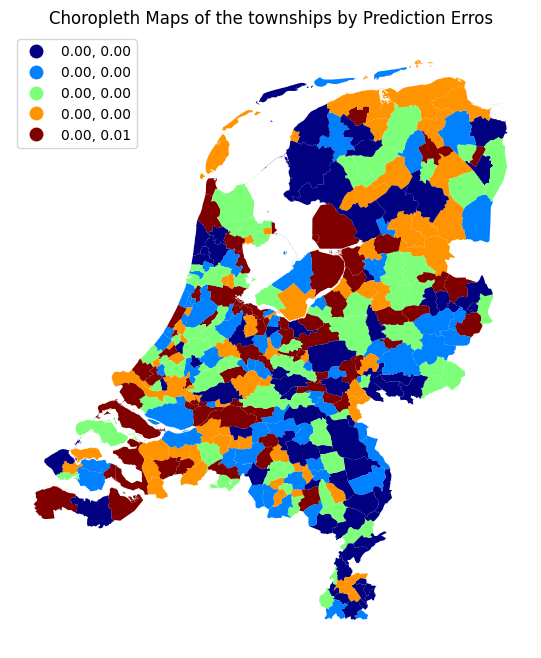

In [ ]:
# nested cross validation to predict the votes of each municipality

# instantiate cross validation for the outer loop and the inner loop
outer_cv = GroupKFold(n_splits=5)
inner_cv = GroupKFold(n_splits=5)
all_errors = np.zeros(len(town))

# outer loop to split the data into 5 folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups=town['GrootOuderRegioCode'])):
  print(f'Fold {i}')

  # inner loop to split the data into train and test set
  X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
  y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

  # inner loop for hyperparameter tuning
  model = RandomForestRegressor()
  param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5]}
  grid = GridSearchCV(model,
                      param_grid=param_grid,
                      cv=inner_cv,
                      scoring='neg_mean_squared_error')
  grid.fit(X_train, y_train, groups=town['GrootOuderRegioCode'].iloc[train_idx])

  regressor = grid.best_estimator_
  y_pred = regressor.predict(X_test)

  err = mean_squared_error(y_test, y_pred)
  err_per_mun = (y_pred - y_test) ** 2
  all_errors[test_idx] = err_per_mun
  print('The mean squared error:', err)

#
town.assign(cl=all_errors).plot(figsize=(8, 8), column='cl', scheme='QUANTILES', k=5, cmap='jet', legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Choropleth Maps of the townships by Prediction Erros')
plt.axis('off')
plt.show()